This is the final lab!

Link to our online report: https://typst.app/project/wh8vY0BQTzXHKzTLXigIDf

We can devide the task into:
1. Implement the Adaboost(DONE)
2. Generate the model selection procedure for Adaboost(Need to work on)
3. Document all the steps
4. Write the report

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import perceptron as pc
from sklearn.metrics import f1_score 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score




In [2]:
# Load the dataset
digits = load_digits()
X = digits.data
y = digits.target
# Print dataset details
print("Shape of data (features):", digits.data.shape)  # Feature matrix (n_samples, n_features)
print("Shape of images:", digits.images.shape)        # Images (n_samples, 8, 8)
print("Shape of target:", digits.target.shape)        # Labels (n_samples,)
print("Target classes:", np.unique(digits.target))    # Unique digit classes


Shape of data (features): (1797, 64)
Shape of images: (1797, 8, 8)
Shape of target: (1797,)
Target classes: [0 1 2 3 4 5 6 7 8 9]


In [3]:
from sklearn.model_selection import train_test_split


# Function to plot target value distributions
def plot_target_distribution(y, split_name):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color='skyblue', edgecolor='black')
    plt.xticks(unique)
    plt.title(f"Target Value Distribution in {split_name}")
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.show()
    
def Accuracy(y_pred, y):
    '''
    OUTPUT :
    - accuracy: compare two outputs, calculate their accuracy
    '''
    val_accuracy = np.mean(y_pred == y)
    print(f"Testing Accuracy: {val_accuracy * 100:.2f}%")
    return val_accuracy

# Plot distributions for each split
#plot_target_distribution(y_train, "Training Set")
#plot_target_distribution(y_test, "Test Set")

In [4]:
# Split into train + test(The split of validation is in training session)

# Split 80% for training and 20% for validation + testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split 50% of the remaining 20% into validation and testing (10% each)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
'''
# Store the binary labels for all classes
binary_y_train = {}
binary_y_valid = {}
binary_y_test = {}

# Iterate over each digit (0 to 9)
for k in range(10):
    # Create binary labels for class k in training set
    y_train_k = np.copy(y_train)
    y_train_k[y_train_k != k] = -1  # Set all other classes to -1
    y_train_k[y_train_k == k] = 1   # Set class k to 1
    binary_y_train[k] = y_train_k
    
    # Create binary labels for class k in training set
    y_valid_k = np.copy(y_valid)
    y_valid_k[y_valid_k != k] = -1  # Set all other classes to -1
    y_valid_k[y_valid_k == k] = 1   # Set class k to 1
    binary_y_valid[k] = y_valid_k

    # Create binary labels for class k in test set
    y_test_k = np.copy(y_test)
    y_test_k[y_test_k != k] = -1  # Set all other classes to -1
    y_test_k[y_test_k == k] = 1   # Set class k to 1
    binary_y_test[k] = y_test_k

'''
# Now binary_y_train[k], binary_y_valid and binary_y_test[k] contain the binary labels for digit k
# This split will maintain until the whole SAMME is trained


In [5]:
X_train.shape, X_valid.shape, X_test.shape

((1437, 64), (180, 64), (180, 64))

In [39]:
# Perceptron functions

def Perceptron_train(alpha, epoch, weight_samples, 
                     X_train_fold, y_train_fold, 
                     X_val_fold, y_val_fold):
    """
    Train Perceptron models for each class (0..9) with weighted samples, 
    but specifically on this fold's X_train_fold, y_train_fold.
    
    Returns:
      models: dict of {digit_k: trained Perceptron}
      error: float, combined weighted error
      y_Pred: array of shape (len(X_train_fold), ), multi-class predictions
      f1s: dict of per-digit F1 scores
    """
    accuracy = {}
    f1s = {}
    models = {}

    n_samples_fold = len(y_train_fold)

    # For storing final multi-class predictions on this fold's training set
    fill_value = -1
    y_Pred_fold = np.full(n_samples_fold, fill_value)

    # Iterate training over each digit (0 to 9)
    for k in range(10):
        print(f"Training Model for Class {k}")
        
        # Create binary labels for digit k in this fold
        # (Instead of referencing binary_y_train[k], do it inline)
        y_train_k = np.where(y_train_fold == k, 1, -1)
        y_val_k   = np.where(y_val_fold == k, 1, -1)

        # Initialize Perceptron model
        model_k = pc.Perceptron(alpha)
        
        # OLD: model_k.train(X_train, X_valid, binary_y_train[k], binary_y_valid[k], weight_samples, epochs=epoch)
        # NEW: pass the fold's data
        model_k.train(X_train_fold, X_val_fold, 
                      y_train_k, y_val_k, 
                      weight_samples, epochs=epoch)
        
        # We won't do "evaluate on X_test" here, because for cross-validation, there's no global test.
        # If you do want to see performance on the fold's val, do:
        y_val_pred_k = model_k.predict(X_val_fold)
        # maybe measure something if you want

        # Evaluate on the fold's training set to get misclassifications for the final error
        y_pred_k_train = model_k.predict(X_train_fold)

        # F1 score for this digit on training set
        prec_k, rec_k, f1_k = model_k.precision_recall_f1(y_pred_k_train, y_train_k)
        f1s[k] = f1_k

        # Combine predictions for multi-class on the training fold
        # If model k claims sample i => y_pred_k_train[i] == 1 => candidate digit
        for i in range(n_samples_fold):
            if y_pred_k_train[i] == 1:
                if y_Pred_fold[i] == -1:
                    y_Pred_fold[i] = k
                else:
                    # conflict => pick the digit with higher f1
                    current_class = y_Pred_fold[i]
                    if f1s[k] > f1s[current_class]:
                        y_Pred_fold[i] = k

        models[k] = model_k
    
    # Weighted error = sum of sample weights for misclassified samples
    misclassified = (y_Pred_fold != y_train_fold)
    error = np.sum(weight_samples[misclassified]) / np.sum(weight_samples)

    # If you want to see combined accuracy on the fold's training set:
    combined_acc = np.mean(y_Pred_fold == y_train_fold)
    combined_f1  = f1_score(y_train_fold, y_Pred_fold, average='macro')
    print(f"Combined train fold Accuracy: {combined_acc*100:.2f}%")
    print(f"Combined train fold F1: {combined_f1:.2f}")
    print(f"Combined Weighted Error: {error:.4f}\n")
    
    return models, error, y_Pred_fold, f1s

def Combined_predict(Models, X, Y, f1s):
    # Combine predictions for the multi-class task
    fill_value = -1  # Placeholder for unclassified samples
    y_Pred = np.full_like(Y, fill_value)  # Initialize predictions
    for k in range(10):
        y_pred_k = Models[k].predict(X)
        y_Pred[(y_pred_k == 1) & (y_Pred == fill_value)] = k  # Assign if unclassified
        # Update predictions for conflicts based on F1 scores
        conflict_indices = np.where((y_pred_k == 1) & (y_Pred != fill_value))[0]
        for idx in conflict_indices:
            current_class = y_Pred[idx]  # Existing predicted class
            if f1s[k] > f1s[current_class]:  # Compare F1 scores
                y_Pred[idx] = k  # Update to more reliable prediction
    return y_Pred




In [41]:
# SAMME & kfold Functions
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

def SAMME_predict_optimized(Weak_classifier_perceptrons, X_valid, y_valid, F1s, weight_Weak_classifier, n_classes=10, text = 'Final'):
    """
    Perform SAMME prediction by combining weighted votes from weak classifiers efficiently.

    """
    n_samples = X_valid.shape[0]
    votes = np.zeros((n_samples, n_classes))  # Accumulate votes for each class

    for t in range(len(Weak_classifier_perceptrons)):
        # Predict for all samples at once using the weak classifiers
        predictions_t = Combined_predict(Weak_classifier_perceptrons[t], X_valid, y_valid, F1s[t])
        valid_indices = predictions_t != -1  # Only count valid predictions

        # Update votes for valid predictions
        votes[valid_indices, predictions_t[valid_indices]] += weight_Weak_classifier[t]

    # Final prediction: the class with the most votes
    y_pred = np.argmax(votes, axis=1)

    # Evaluate final model
    accuracy = np.mean(y_pred == y_valid)
    f1 = f1_score(y_valid, y_pred, average='macro')
    print(text,f" SAMME Accuracy: {accuracy * 100:.2f}%")
    print(text,f" SAMME F1-score: {f1:.2f}")
    
    return y_pred, accuracy, f1

def run_samme(X_train_fold, y_train_fold, X_val_fold, y_val_fold,
              T=5, alpha=0.01, epoch=10):
    n_samples = len(y_train_fold) # this gives issues if n_samples !=  len(y_train_fold)
    weight_samples = np.ones(n_samples)/n_samples
    n_classes = 10
    
    Weak_classifier_perceptrons = {}
    weight_Weak_classifier = {}
    F1s = {}

    for t in range(T):
        Models_temp, Error, y_Pred_fold, f1s_dict = Perceptron_train(
            alpha, epoch, weight_samples,
            X_train_fold, y_train_fold, 
            X_val_fold, y_val_fold
        )
        if Error >= 0.5:
            print("Classifier has high error, skipping.\n")
            continue
        
        F1s[t] = f1s_dict
        Weak_classifier_perceptrons[t] = Models_temp
        alpha_t = np.log((1 - Error)/Error) + np.log(n_classes -1)
        weight_Weak_classifier[t] = alpha_t
        
        # Update sample weights
        for i in range(n_samples):
            if y_Pred_fold[i] != y_train_fold[i]:
                weight_samples[i] *= np.exp(alpha_t)
        weight_samples /= np.sum(weight_samples)
    

    return Weak_classifier_perceptrons, F1s, weight_Weak_classifier


def cross_val_samme(X, y, T, alpha, epoch, n_splits=5): # K FOLD SAMME
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_f1s = []
    acc_vals = []
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        Weak_classifier_perceptrons,F1s,weight_Weak_classifier = run_samme(
            X_train_fold, y_train_fold,
            X_val_fold, y_val_fold,
            T=T, alpha=alpha, epoch=epoch
        )
        # final predictions on X_val_fold
        # do SAMME_predict_optimized
        y_val_pred, acc_val, f1_val = SAMME_predict_optimized(
        Weak_classifier_perceptrons,
        X_val_fold,
        y_val_fold,
        F1s,
        weight_Weak_classifier
    )
        fold_f1s.append(f1_val)
        acc_vals.append(acc_val)
        print(f"Fold {fold_idx} F1: {f1_val:.2f}")
    
    avg_f1 = np.mean(fold_f1s)
    avg_acc = np.mean(acc_vals)
    print(f"Average F1 across {n_splits} folds: {avg_f1:.2f}")
    print(f"Average accuracy across {n_splits} folds: {avg_acc:.2f}")
    return avg_f1,avg_acc




In [19]:
T_candidates = [3, 5, 10]
alpha_candidates = [0.001, 0.005, 0.01, 0.1]
epoch_candidates = [10, 20, 30, 50]


best_score = -1.0
best_params = None
params = {}

y_binary = np.where(y == 0, 1, -1)  # e.g., digit 0 as +1, others as -1
X_binary = X  # same features
f1_cvs = []
acc_cvs = []
i = 1
for T_ in T_candidates:
    for alpha_ in alpha_candidates:
        for epoch_ in epoch_candidates:
            f1_cv,acc_cv = cross_val_samme(X, y, T_, alpha_, epoch_, n_splits=5)
            f1_cvs.append(f1_cv)
            acc_cvs.append(acc_cv)
            params[i] = (T_, alpha_, epoch_, f1_cv, acc_cv)
            i+=1
            if f1_cv > best_score:
                best_score = f1_cv
                best_params = (T_, alpha_, epoch_)

print("Best params from CV:", best_params, "score:", best_score)

Training Model for Class 0
Validation Accuracy: 98.89%
Validation precision: 100.00%
Validation recall: 87.88%
Validation f1_score: 0.94
Training Model for Class 1
Validation Accuracy: 96.94%
Validation precision: 71.79%
Validation recall: 100.00%
Validation f1_score: 0.84
Training Model for Class 2
Validation Accuracy: 98.89%
Validation precision: 89.19%
Validation recall: 100.00%
Validation f1_score: 0.94
Training Model for Class 3
Validation Accuracy: 93.61%
Validation precision: 59.65%
Validation recall: 100.00%
Validation f1_score: 0.75
Training Model for Class 4
Validation Accuracy: 99.44%
Validation precision: 100.00%
Validation recall: 95.65%
Validation f1_score: 0.98
Training Model for Class 5
Validation Accuracy: 96.11%
Validation precision: 100.00%
Validation recall: 70.21%
Validation f1_score: 0.82
Training Model for Class 6
Validation Accuracy: 99.17%
Validation precision: 97.06%
Validation recall: 94.29%
Validation f1_score: 0.96
Training Model for Class 7
Validation Accu

In [20]:
params

{1: (3, 0.001, 10, 0.9156633641654626, 0.9159656453110492),
 2: (3, 0.001, 20, 0.9328572228361048, 0.9337790157845868),
 3: (3, 0.001, 30, 0.9295986708860609, 0.9298700092850511),
 4: (3, 0.001, 50, 0.9285012356020953, 0.9287650882079852),
 5: (3, 0.005, 10, 0.908296851146634, 0.9093036211699165),
 6: (3, 0.005, 20, 0.9192602539257013, 0.9198653667595172),
 7: (3, 0.005, 30, 0.9297337170433121, 0.9304472299597648),
 8: (3, 0.005, 50, 0.9326675324657702, 0.9332250077375426),
 9: (3, 0.01, 10, 0.908296851146634, 0.9093036211699165),
 10: (3, 0.01, 20, 0.9192602539257013, 0.9198653667595172),
 11: (3, 0.01, 30, 0.9297337170433121, 0.9304472299597648),
 12: (3, 0.01, 50, 0.9326675324657702, 0.9332250077375426),
 13: (3, 0.1, 10, 0.9095017919654541, 0.9104178272980501),
 14: (3, 0.1, 20, 0.9258887717384221, 0.9265444134942742),
 15: (3, 0.1, 30, 0.9322715718002227, 0.9332141751779636),
 16: (3, 0.1, 50, 0.9331090633327094, 0.9332234602290314),
 17: (5, 0.001, 10, 0.9289845222144578, 0.92931

In [26]:
best_T, best_alpha, best_epoch = best_params
print({ best_T,best_alpha, best_epoch})

# f1_final, y_test_pred = run_samme(
#     X_train_final, y_train_final,
#     X_test, y_test,
#     T=best_T, alpha=best_alpha, epoch=best_epoch
# )


{0.1, 10, 50}


In [47]:
Weak_classifier_perceptrons,F1s,weight_Weak_classifier = run_samme(
            X_train, y_train,
            X_valid, y_valid,
            T=best_T, alpha=best_alpha, epoch=best_epoch
        )



Training Model for Class 0
Validation Accuracy: 100.00%
Validation precision: 100.00%
Validation recall: 100.00%
Validation f1_score: 1.00
Training Model for Class 1
Validation Accuracy: 98.89%
Validation precision: 93.33%
Validation recall: 93.33%
Validation f1_score: 0.93
Training Model for Class 2
Validation Accuracy: 98.89%
Validation precision: 93.75%
Validation recall: 93.75%
Validation f1_score: 0.94
Training Model for Class 3
Validation Accuracy: 97.22%
Validation precision: 93.33%
Validation recall: 77.78%
Validation f1_score: 0.85
Training Model for Class 4
Validation Accuracy: 99.44%
Validation precision: 100.00%
Validation recall: 95.65%
Validation f1_score: 0.98
Training Model for Class 5
Validation Accuracy: 98.89%
Validation precision: 93.10%
Validation recall: 100.00%
Validation f1_score: 0.96
Training Model for Class 6
Validation Accuracy: 99.44%
Validation precision: 100.00%
Validation recall: 95.65%
Validation f1_score: 0.98
Training Model for Class 7
Validation Accu

In [48]:
#validate error
y_val_pred, acc_val, f1_val = SAMME_predict_optimized(
        Weak_classifier_perceptrons,
        X_valid,
        y_valid,
        F1s,
        weight_Weak_classifier,
        text = "Validate"
    )
# testing error
y_pred, acc_val, f1_val = SAMME_predict_optimized(
        Weak_classifier_perceptrons,
        X_test,
        y_test,
        F1s,
        weight_Weak_classifier,
        text = "Test"
    )

Validate  SAMME Accuracy: 95.56%
Validate  SAMME F1-score: 0.95
Test  SAMME Accuracy: 95.56%
Test  SAMME F1-score: 0.96


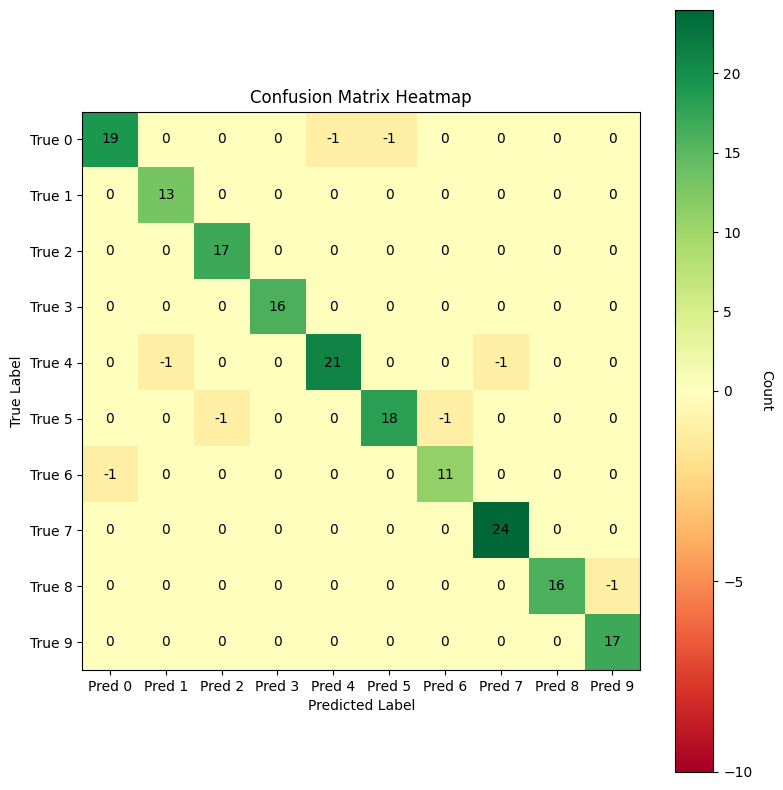

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Recreating the confusion matrix for visualization (adjust as needed for real data)
confusion_matrix = np.zeros((10, 10))
for t, p in zip(y_test, y_pred):
    if t==p:
        confusion_matrix[t, p] += 1
    if t!=p:
        confusion_matrix[t, p] -= 1

# Setting up the color map with white at 0, red for negatives, green for positives
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=confusion_matrix.max())
cmap = plt.cm.RdYlGn

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(confusion_matrix, cmap=cmap, norm=norm)

# Adding color bar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Count", rotation=270, labelpad=15)

# Labeling the axes
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels([f"Pred {i}" for i in range(10)])
ax.set_yticklabels([f"True {i}" for i in range(10)])

# Adding annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, int(confusion_matrix[i, j]),
                       ha="center", va="center",
                       color="black")

# Adding gridlines for better visualization
ax.set_title("Confusion Matrix Heatmap")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()
